In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

In [2]:
f = h5py.File('/data/user/dfuchsgruber/all_energies.hd5')

In [3]:
num_vertices = np.log10(np.array(f['NumberVertices']))
zenith = np.cos(np.array(f['PrimaryZenith']))

In [4]:
class_idx = np.array(f['classification'])
# Reclassify
class_idx[class_idx == 22] = 2
class_idx[class_idx == 23] = 4
class_idx[class_idx == 11] = 0

#dict(zip(class_idx, counts))

In [5]:
values = np.array([num_vertices, zenith]).T
values.shape

(32207472, 2)

In [6]:
sampled = np.zeros(values.shape[0]).astype(np.bool)
for class_label in (0, 1, 2, 3, 4):
    print((class_idx == class_label).astype(np.int).sum())
    sampled[class_idx == class_label] = True

7354660
4786117
7247729
8179063
3724840


(array([ 0,  2,  4, ...,  1,  5, 12], dtype=int32), 'red')
(array([ 0,  2,  4, ...,  1,  5, 12], dtype=int32), 'blue')
(array([ 0,  2,  4, ...,  1,  5, 12], dtype=int32), 'green')
(array([ 0,  2,  4, ...,  1,  5, 12], dtype=int32), 'black')
(array([ 0,  2,  4, ...,  1,  5, 12], dtype=int32), 'orange')


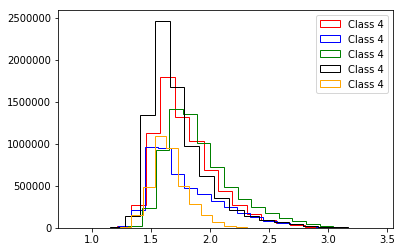

In [7]:
for label, color in enumerate(('red', 'blue', 'green', 'black', 'orange')):
    print(class_idx, color)
    plt.hist(num_vertices[sampled][class_idx[sampled] == label], bins=20, fill=False, histtype='step', color=color, label='Class ' + str(class_label))
plt.legend()

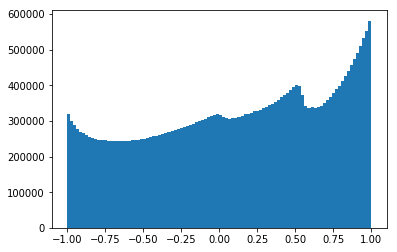

In [8]:
plt.hist(zenith, bins=100)
None

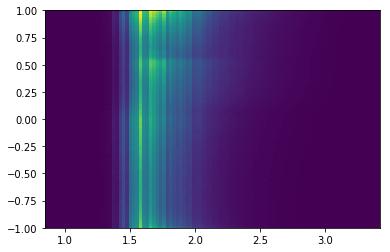

In [9]:
plt.hist2d(values[:,0], values[:,1], bins=100)
None

In [10]:
def sample_to_uniform_distribution(value, bins, expected_bin_size=None):
    """ Takes a sample so that the distribution of value is approximately uniform."""
    counts, edges = np.histogram(value, bins=bins)
    bin_idxs = np.digitize(value, edges)
    # Move values outside the bins into the bins
    bin_idxs -= 1
    bin_idxs[bin_idxs == bins] = bins - 1
    if expected_bin_size is None:
        expected_bin_size = value.shape[0] / (bins * 2.1)
    print 'Keep', expected_bin_size, 'events per bin'
    keep_probability = (expected_bin_size / (counts + 1e-12))[bin_idxs]
    keep_probability[keep_probability > 1] = 1.0
    #plt.hist(keep_probability)
    #plt.hist((expected_events_per_bin / (counts + 1e-9)), bins=100)
    #lt.hist(value, bins=100)
    sampled = np.random.uniform(low=0, high=1, size=value.shape[0]) <= keep_probability
    
    return sampled

In [11]:
def sample_to_uniform_distribution_masked(value, mask, bins):
    mask2 = sample_to_uniform_distribution(value[mask], bins)
    idx = np.where(mask)
    # Extend mask2 to the right dimension
    resized = np.zeros_like(value).astype(np.bool)
    resized[idx] = mask2
    return resized

In [12]:
def sample_to_equal_class_distribution(value, classes, bins):
    sampled = np.zeros_like(value).astype(np.bool)
    
    # Compute the minimal bin size among all classes
    _, edges = np.histogram(value, bins=bins)
    num_classes = len(np.unique(classes))
    counts = np.zeros(shape=(edges.shape[0] - 1, num_classes))
    for class_label in np.unique(classes):
        counts_class, _ = np.histogram(value[classes == class_label], bins=edges)
        counts[:,class_label] =  counts_class
    expected_bin_sizes = np.min(counts, axis=1)
    print('Computed bin sizes among all classes')
    
    # For each class compute the bin sizes and sample accordingly
    for class_label in np.unique(classes):
        value_class = value[classes == class_label]
        counts_class, _ = np.histogram(value_class, bins=edges)
        bin_idxs = np.digitize(value_class, edges)
        # Move values outside the bins into the bins
        bin_idxs -= 1
        bin_idxs[bin_idxs == bins] = bins - 1
        keep_probability = (expected_bin_sizes / (counts_class + 1e-12))[bin_idxs]
        keep_probability[keep_probability > 1] = 1.0
        sampled[classes == class_label] = np.random.uniform(low=0, high=1, size=value_class.shape[0]) <= keep_probability
        print('Drew samples ',  sampled[classes == class_label].sum(), 'from class', class_label)
        
    return sampled
        
    

In [13]:
def sample_to_equal_class_distribution_masked(value, classes, mask, bins):
    mask_reduced = sample_to_equal_class_distribution(value[mask], classes[mask], bins)
    # Extend mask2 to the right dimension
    resized = np.zeros_like(value).astype(np.bool)
    resized[mask] = mask_reduced
    return resized

In [14]:
print('Ratio of exclude vs. included samples after discarding classes')
np.unique(sampled, return_counts=True)

Ratio of exclude vs. included samples after discarding classes


(array([False,  True]), array([  915063, 31292409]))

In [15]:
# Exclude class #4 from vertex sampling, because it will follow a different distribution
sampled_without_class_4 = sampled.copy()
sampled_without_class_4[class_idx == 4] = False

In [16]:
sampled_vertex_without_class_4 = sample_to_equal_class_distribution_masked(num_vertices, class_idx, sampled_without_class_4, 5000)
print 'Sampled from', len(np.unique(class_idx[sampled_vertex_without_class_4])), 'different classes'

Computed bin sizes among all classes
('Drew samples ', 3709877, 'from class', 0)
('Drew samples ', 3711779, 'from class', 1)
('Drew samples ', 3716472, 'from class', 2)
('Drew samples ', 3712854, 'from class', 3)
Sampled from 4 different classes


In [17]:
# Re-include vertices from class #4, but sample ~the same amount of events the other classes have
_, class_counts = np.unique(class_idx[sampled_vertex_without_class_4], return_counts=True)
average_number_events_per_class = np.mean(class_counts)
number_events_class_4 = (class_idx == 4).sum()
keep_probability = average_number_events_per_class / number_events_class_4
print ('Keep probability for class 4 is', keep_probability)


sampled_vertex = sampled_vertex_without_class_4.copy()
sampled_vertex[class_idx == 4] = np.random.uniform(low=0, high=1, size=sampled_vertex[class_idx == 4].shape[0]) <= keep_probability

('Keep probability for class 4 is', 0.9967530148945996)


In [18]:
print('Ratio of exclude vs. included samples after sampling to have equal distributions in #vertexs among classes')
np.unique(sampled_vertex, return_counts=True)

Ratio of exclude vs. included samples after sampling to have equal distributions in #vertexs among classes


(array([False,  True]), array([13643855, 18563617]))

In [19]:
# Sample a uniform zenith distribution within each class
sampled_zenith = sampled_vertex.copy()
for class_label in reversed(np.unique(class_idx[sampled_vertex])):
    sampled_zenith[class_idx == class_label] = sample_to_uniform_distribution_masked(zenith[class_idx == class_label], 
                                                           sampled_vertex[class_idx == class_label], 5000)
    print 'Sampled zenith distriubtion for class', class_label
    
    

Keep 353.584285714 events per bin
Sampled zenith distriubtion for class 4
Keep 353.605142857 events per bin
Sampled zenith distriubtion for class 3
Keep 353.949714286 events per bin
Sampled zenith distriubtion for class 2
Keep 353.502761905 events per bin
Sampled zenith distriubtion for class 1
Keep 353.321619048 events per bin
Sampled zenith distriubtion for class 0


In [20]:
print('Ratio of exclude vs. included samples after discarding classes & fixing cos(zenith distribution)')
np.unique(sampled_zenith, return_counts=True)

Ratio of exclude vs. included samples after discarding classes & fixing cos(zenith distribution)


(array([False,  True]), array([23372319,  8835153]))

In [21]:
assert len(np.unique(class_idx[sampled_zenith])) == 5

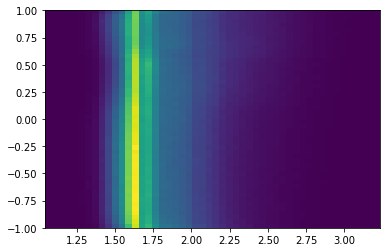

In [22]:
plt.hist2d(values[sampled_zenith][:,0], values[sampled_zenith][:,1], bins=50)
None

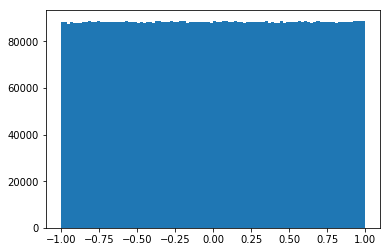

In [23]:
plt.hist(zenith[sampled_zenith], bins=100)
None

(array([ 0,  2,  4, ...,  1,  5, 12], dtype=int32), 'red')
(array([ 0,  2,  4, ...,  1,  5, 12], dtype=int32), 'blue')
(array([ 0,  2,  4, ...,  1,  5, 12], dtype=int32), 'green')
(array([ 0,  2,  4, ...,  1,  5, 12], dtype=int32), 'black')
(array([ 0,  2,  4, ...,  1,  5, 12], dtype=int32), 'orange')


No handlers could be found for logger "matplotlib.legend"


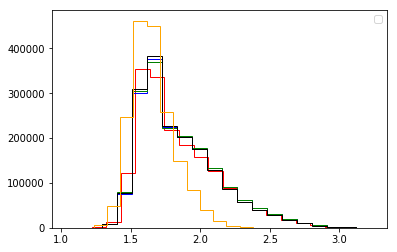

In [24]:
for label, color in enumerate(('red', 'blue', 'green', 'black', 'orange')):
    print(class_idx, color)
    plt.hist(num_vertices[sampled_zenith][class_idx[sampled_zenith] == label], bins=20, fill=False, histtype='step', color=color)
plt.legend()

(array([ 0,  2,  4, ...,  1,  5, 12], dtype=int32), 'red')
(array([ 0,  2,  4, ...,  1,  5, 12], dtype=int32), 'blue')
(array([ 0,  2,  4, ...,  1,  5, 12], dtype=int32), 'green')
(array([ 0,  2,  4, ...,  1,  5, 12], dtype=int32), 'black')
(array([ 0,  2,  4, ...,  1,  5, 12], dtype=int32), 'orange')


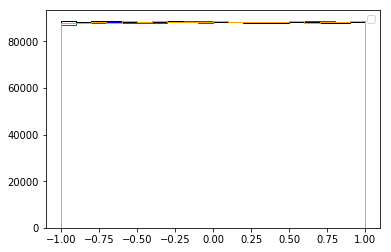

In [25]:
for label, color in enumerate(('red', 'blue', 'green', 'black', 'orange')):
    print(class_idx, color)
    plt.hist(zenith[sampled_zenith][class_idx[sampled_zenith] == label], bins=20, fill=False, histtype='step', color=color)
plt.legend()

In [14]:
# Sample #vertices
n_bins = 1000
counts, edges = np.histogram(num_vertices, bins=n_bins)
bin_idxs = np.digitize(num_vertices, edges) - 1
bin_idxs[bin_idxs == n_bins] = n_bins - 1
print np.sort(np.unique(counts))[:25]
expected_events_per_bin = num_vertices.shape[0] / n_bins
keep_probability = (expected_events_per_bin / (counts + 1e-9))[bin_idxs]
p = np.random.uniform(size=num_vertices.shape[0])
sampled = p <= keep_probability


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]


4104

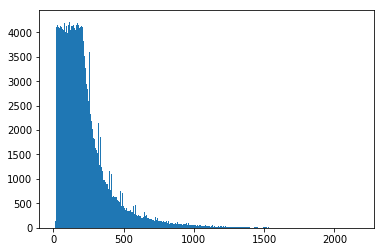

In [12]:
plt.hist(num_vertices[sampled], bins=n_bins)
expected_events_per_bin

In [ ]:
sampled = n

In [82]:
n_bins = 200

In [83]:
count, x_edges, y_edges, bin_assignment = scipy.stats.binned_statistic_2d(values[:,0], values[:,1], None, statistic='count', bins=n_bins)
bin_x, bin_y = np.unravel_index(bin_assignment,
                                (len(x_edges) + 1, len(y_edges) + 1))
bin_x.shape, bin_y.shape

((4104907,), (4104907,))

In [84]:
# Only consider bins with "enough data"
threshold = count.sum() / n_bins**2
(count >= threshold).sum(), count.shape, threshold

(3433, (200, 200), 102.622675)

In [85]:
bin_idxs = np.where(count >= threshold)
bin_idxs = np.array(bin_idxs)
bin_idxs.shape
for x, y in bin_idxs.T:
    idxs, = np.where(np.logical_and(bin_x == x + 1, bin_y == y + 1))
    assert idxs.shape[0] >= threshold
    # Sample threshold from the idxs
    s = np.random.choice(idxs, size=int(threshold), replace=False)
    sampled[s] = True

In [91]:
sampled.sum() / int(threshold)

3433

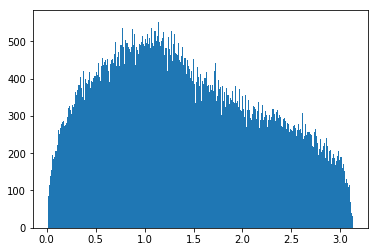

In [88]:
plt.hist(zenith[sampled], bins=1000)
None

(array([[ 0., 13.,  5., ...,  7.,  6.,  0.],
        [ 0., 33., 41., ..., 34., 41.,  0.],
        [ 0., 74., 63., ..., 81., 81.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]),
 array([ 20.  ,  22.92,  25.84,  28.76,  31.68,  34.6 ,  37.52,  40.44,
         43.36,  46.28,  49.2 ,  52.12,  55.04,  57.96,  60.88,  63.8 ,
         66.72,  69.64,  72.56,  75.48,  78.4 ,  81.32,  84.24,  87.16,
         90.08,  93.  ,  95.92,  98.84, 101.76, 104.68, 107.6 , 110.52,
        113.44, 116.36, 119.28, 122.2 , 125.12, 128.04, 130.96, 133.88,
        136.8 , 139.72, 142.64, 145.56, 148.48, 151.4 , 154.32, 157.24,
        160.16, 163.08, 166.  , 168.92, 171.84, 174.76, 177.68, 180.6 ,
        183.52, 186.44, 189.36, 192.28, 195.2 , 198.12, 201.04, 203.96,
        206.88, 209.8 , 212.72, 215.64, 218.56, 221.48, 224.4 , 227.32,
        230.24, 233.16, 236.08, 239.  , 241.92, 244.84, 247.76, 250

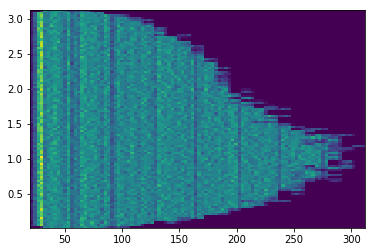

In [93]:
plt.hist2d(values[sampled][:,0], values[sampled][:,1], bins=100)